# 시계열 분석 연습문제
## 문제 1
- 다음의 데이터는 1937년 07월 01일부터 2023년 08월 06일까지 서울의 평균 기온을 조사한 자료이다
> https://data.hossam.kr/E06/temperatures_seoul.xlsx
- 이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 앞으로 1년간의 평균 기온을 시각화 하시오.


In [1]:
import sys
sys.path.append("../../")
from helper import set_datetime_index, exp_time_data

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [2]:
origin = read_excel('https://data.hossam.kr/E06/temperatures_seoul.xlsx', index_col = '날짜')
origin.head()
# 데이터 타입 확인 결과 (origin.dtypes), 
# 날짜의 타입이 datetime64[ns]이므로 인덱스로 바로 설정함

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


In [3]:
# 결측치 검사
origin.isna().sum()

# 데이터 검정 - 데이터가 너무 많으므로 (전체를 검정했을 떄 seasonal을 확인하기 어려웠음)
# -> 최신 5년건만으로 검정 시도 (처음 5년건 해도 됨)
df = origin.tail(365*5)
df

,평균기온(℃)
날짜,
2018-08-08,31.0
2018-08-09,28.8
2018-08-10,30.7
2018-08-11,31.0
2018-08-12,30.6
...,...
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0


결측치 수: 0


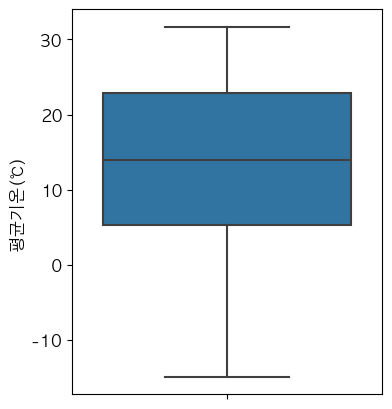

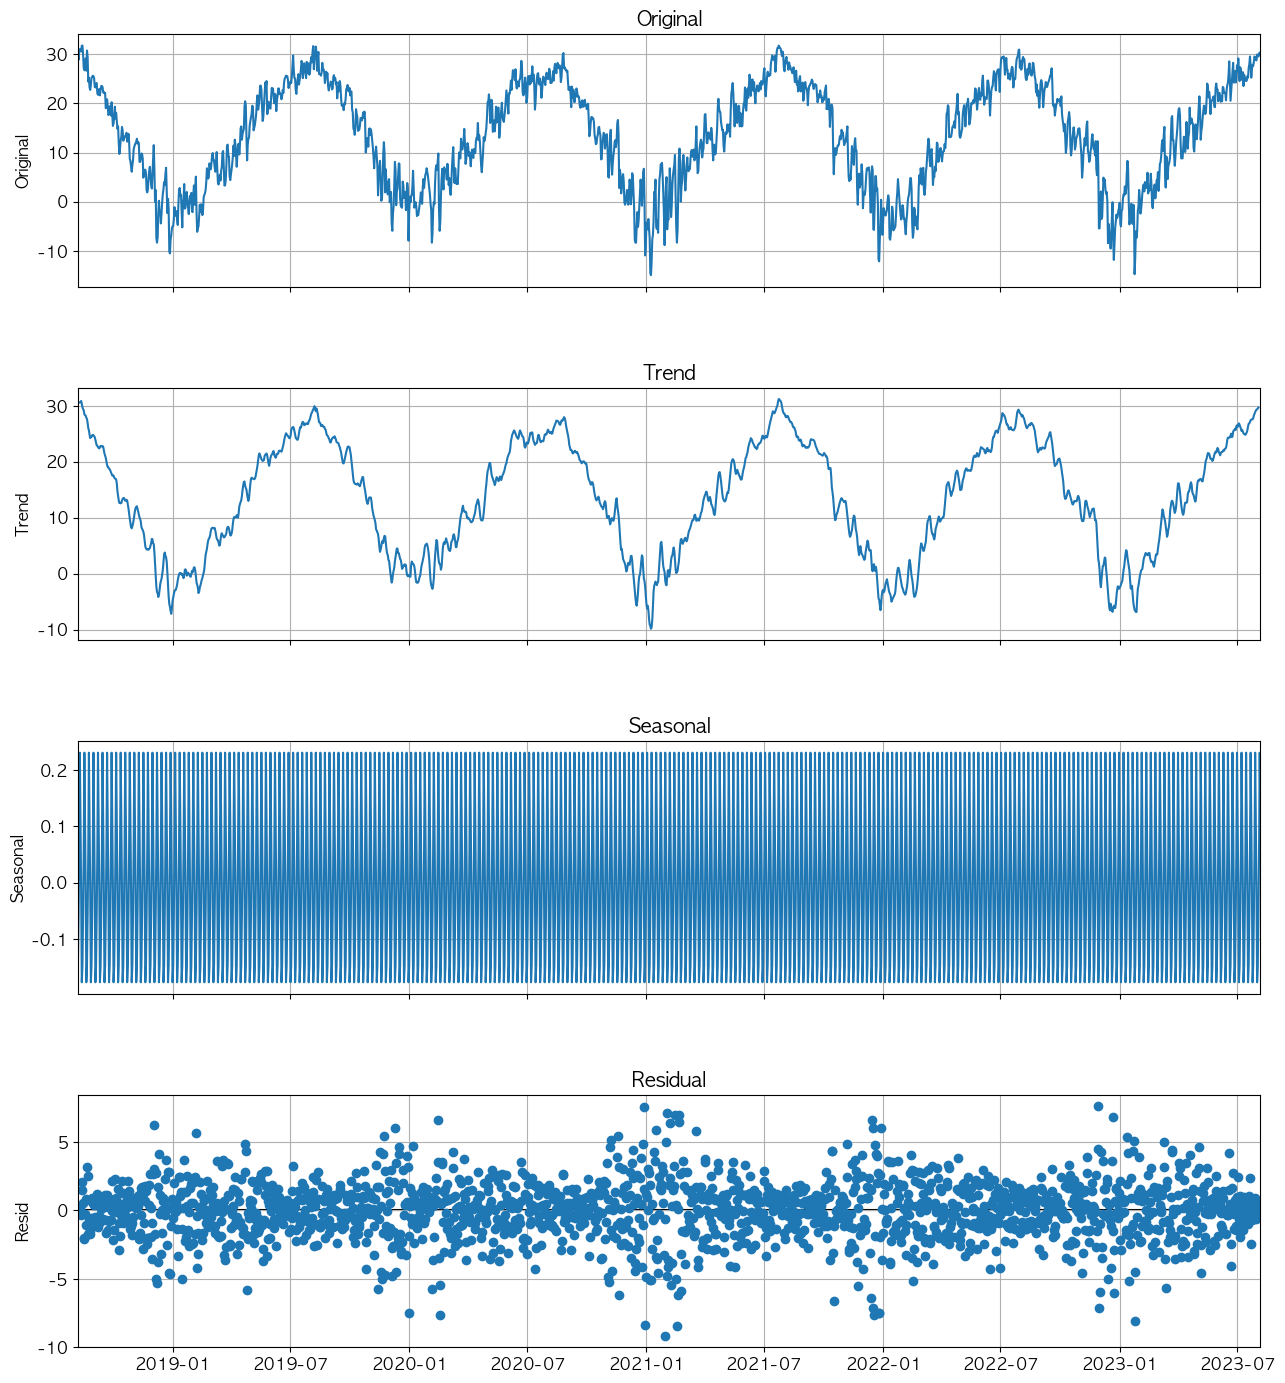

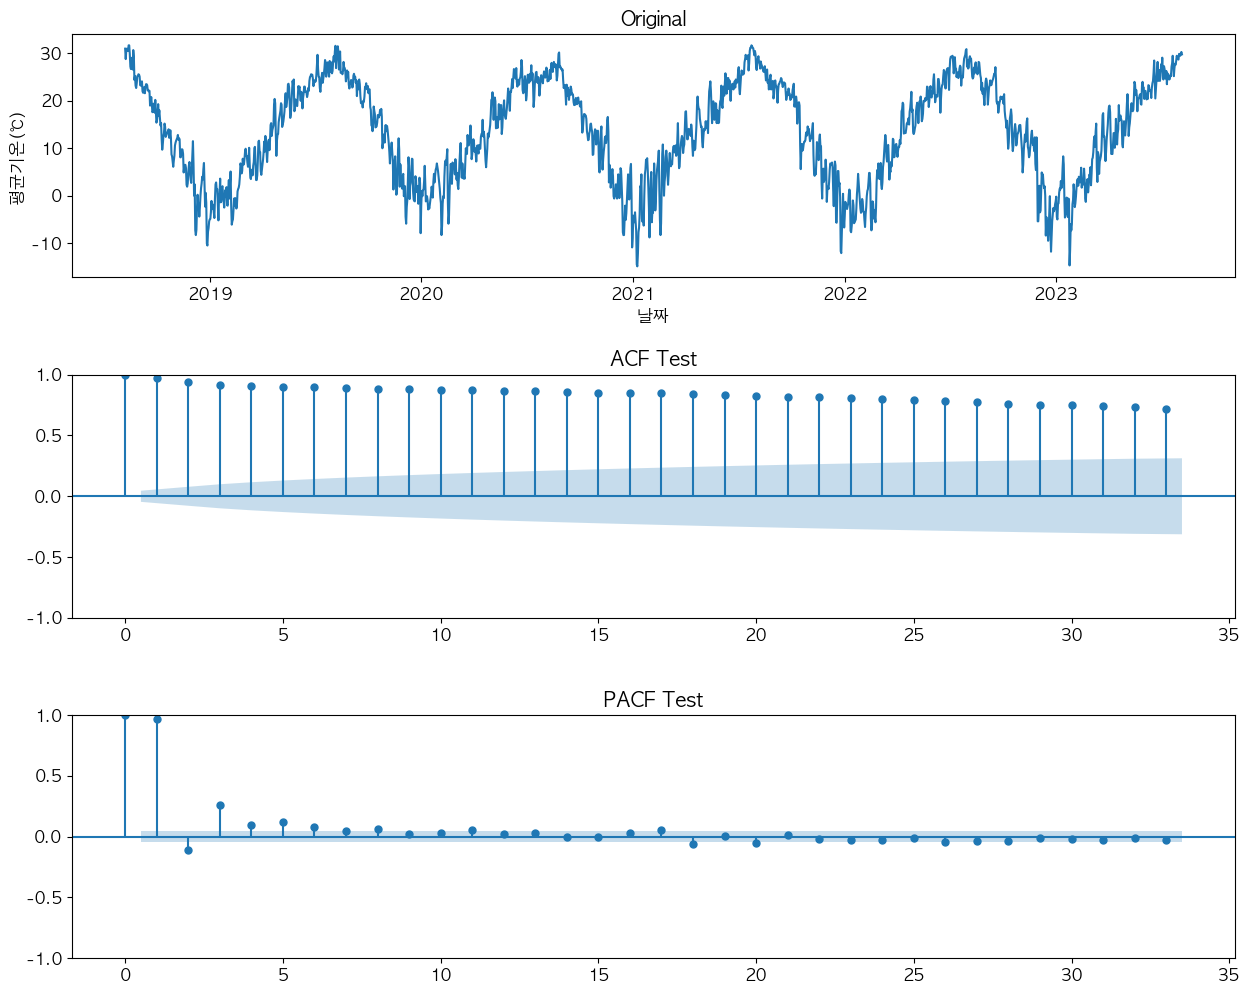

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -2.00483 |
| 유의수준(p-value)                  | 0.284458 |
| 최적차수(num of lags)              |       19 |
| 관측치 개수(num of observations)   |     1805 |
| 기각값(Critical Values) 1%         | -3.43398 |
| 기각값(Critical Values) 5%         | -2.86314 |
| 기각값(Critical Values) 10%        | -2.56762 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -11.4068 |
| 유의수준(p-value)                  | 7.41633e-21 |
| 최적차수(num of lags)              |          18 |
| 관측치 개수(num of observations)   |        1805 |
| 기각값(Critical Va

In [4]:
exp_time_data(data=df, 
              yname='평균기온(℃)',
              sd_model="a", # 덧셈이서 "a"로 설정
              max_diff=10)  # adf test했을 때 차분 미시행 문제 -> `max_diff = 10`으로 설정해서 차분 안 되는거 해결

> 결측치 없음
>
> 계절성을 띄고 있어 보임
>
> ACF test가 더 완만해 보여서 AR(1) 모델로 결정

In [5]:
# ARIMA 분석

# 분석 모델 만들기 - 날씨에 대한 데이터이므로 계절성은 1년마다 돌아온다고 보는 것이 맞지만, 
# 컴퓨터 성능상의 한계로 계절성을 한 달 단위 (=30일)로 제한함

model = ARIMA(df['평균기온(℃)'], 
              order = (1, 1, 0),
              seasonal_order = (1, 1, 0, 30))
my_fit = model.fit()
print(my_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                          평균기온(℃)   No. Observations:                 1825
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -4498.487
Date:                          Tue, 08 Aug 2023   AIC                           9002.974
Time:                                  15:36:01   BIC                           9019.451
Sample:                              08-08-2018   HQIC                          9009.057
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0862      0.020      4.333      0.000       0.047       0.125
ar.S.L30      -0.4916      0.017    -29.565      0.

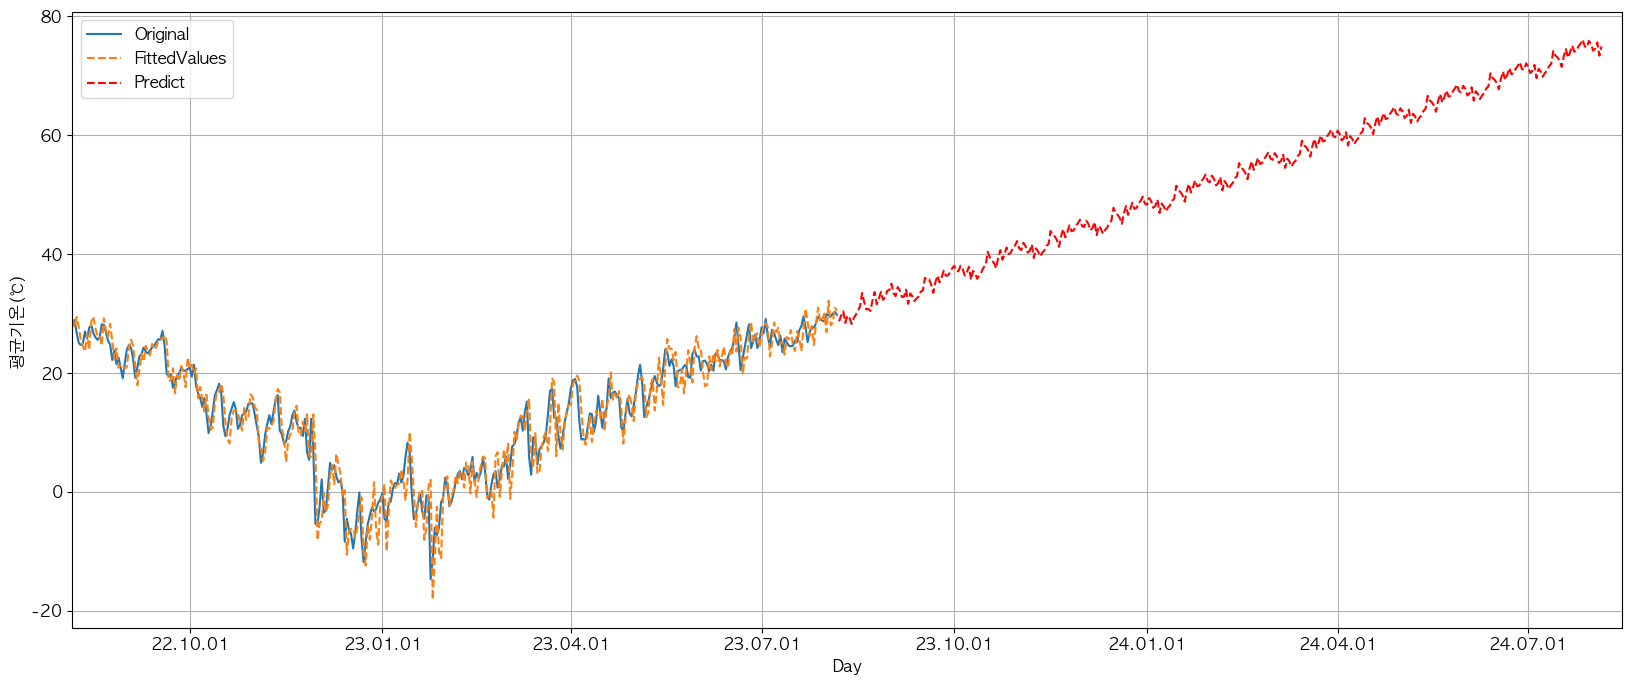

In [6]:
# 학습 모델에 대한 예측치
fv = my_fit.fittedvalues

# 학습한 내용을 토대로 1년간의 예상치 생성
fc = my_fit.forecast(365)

# 시각화
last = origin.index.max()
xmin = last-timedelta(days = 365)
xmax = last+timedelta(days = 365 + 10)
ymax = origin['평균기온(℃)'][xmin:xmax].max()
ymin = origin['평균기온(℃)'][xmin:xmax].min()

plt.figure(figsize = (20, 8))

# 원본 데이터
sb.lineplot(data = origin, x=origin.index, y='평균기온(℃)', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x = fv.index, y=fv.values, label='FittedValues', linestyle = '--')

# 향후 1년 간의 예측값
sb.lineplot(x = fc.index, y=fc.values, label='Predict', linestyle = '--',
            color='red')

plt.xlabel('Day')
plt.ylabel('평균기온(℃)')
plt.legend()
plt.xlim([xmin, xmax])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

## 문제 2
- 다음의 데이터는 1981년 01월부터 2023년 05월까지 전국에서 출생한 신생아 수를 조사하여 시,도별로 표시한 자료이다
> https://data.hossam.kr/E06/newborn.xlsx
- 이 데이터를 활용하여 조사기간동안 전국에서 태어난 신생아 수가 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA중 자신이 사용 가능한 방식 하나를 선정하여 분석하고 앞으로 5년간의 신생아 수를 예측한 자료를 시각화 하시오.

    -> 데이터 전처리 필요

    -> 세종시 경우는 새로 생긴 도시라서 결측치가 있을 것임
    
- 단, 조사되지 않은 항목에 대해서는 신생아수가 0인 것으로 간주한다.
- 최근 5년만 분석! (데이터 너무 많음; 5년도 오래 걸리면 1년 단위로 단축하기)

In [67]:
# 패키지 참조
import sys
sys.path.append('../../')
from helper import set_datetime_index, exp_time_data
from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime, DatetimeIndex
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
import re

In [68]:
# 필요한 데이터 가져오기
origin = read_excel('https://data.hossam.kr/E06/newborn.xlsx')
df_5years = origin.tail(12*5).reset_index().drop('index', axis=1)
df_5years.head()

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,2018년 06월,4603,1659,1188,1630,732.0,794.0,653.0,277.0,7089,633,846,1139,799,890,1341,1688,396
1,2018년 07월,4845,1522,1175,1644,717.0,757.0,672.0,344.0,7317,692,959,1195,810,902,1326,1754,402
2,2018년 08월,4925,1597,1196,1679,794.0,759.0,694.0,280.0,7383,700,882,1208,838,914,1351,1785,396
3,2018년 09월,4687,1476,1111,1631,741.0,712.0,657.0,293.0,7108,696,828,1190,818,913,1214,1605,386
4,2018년 10월,4689,1525,1151,1684,709.0,703.0,664.0,309.0,7358,673,808,1111,807,918,1263,1705,397


In [69]:
# 데이터 전처리 - 인덱스 날짜로 설정
df1 = df_5years.copy()
date = []
for a in range(len(df_5years['시점'])):
    b = df_5years['시점'][a].replace(" ", "")
    date_1 = re.split('년|월', b)
    c = date_1[0]+'-'+date_1[1]
    date.append(c)
for a in range(len(df1['시점'])):
    df1['시점'][a] = date[a]

df1['시점'] = to_datetime(df1['시점'].str.strip(), format='%Y-%m')
df1.dtypes

/var/folders/md/0jpjv9rd2qg156cjt56sczy80000gn/T/ipykernel_27946/3303097647.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['시점'][a] = date[a]
/var/folders/md/0jpjv9rd2qg156cjt56sczy80000gn/T/ipykernel_27946/3303097647.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['시점'][a] = date[a]
/var/folders/md/0jpjv9rd2qg156cjt56sczy80000gn/T/ipykernel_27946/3303097647.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['시

시점         datetime64[ns]
서울특별시               int64
부산광역시               int64
대구광역시               int64
인천광역시               int64
광주광역시             float64
대전광역시             float64
울산광역시             float64
세종특별자치시           float64
경기도                 int64
강원도                 int64
충청북도                int64
충청남도                int64
전라북도                int64
전라남도                int64
경상북도                int64
경상남도                int64
제주특별자치도             int64
dtype: object

In [70]:
# 결측치 검사 및 정제
df1.isna().sum()

시점         0
서울특별시      0
부산광역시      0
대구광역시      0
인천광역시      0
광주광역시      0
대전광역시      0
울산광역시      0
세종특별자치시    0
경기도        0
강원도        0
충청북도       0
충청남도       0
전라북도       0
전라남도       0
경상북도       0
경상남도       0
제주특별자치도    0
dtype: int64

In [76]:
# 날짜 필드를 날짜 형식의 인덱스로 지정
df2 = set_datetime_index(df1, field = '시점', inplace = False)
df2.head()

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
2018-06-01,4603,1659,1188,1630,732.0,794.0,653.0,277.0,7089,633,846,1139,799,890,1341,1688,396
2018-07-01,4845,1522,1175,1644,717.0,757.0,672.0,344.0,7317,692,959,1195,810,902,1326,1754,402
2018-08-01,4925,1597,1196,1679,794.0,759.0,694.0,280.0,7383,700,882,1208,838,914,1351,1785,396
2018-09-01,4687,1476,1111,1631,741.0,712.0,657.0,293.0,7108,696,828,1190,818,913,1214,1605,386
2018-10-01,4689,1525,1151,1684,709.0,703.0,664.0,309.0,7358,673,808,1111,807,918,1263,1705,397


In [77]:
# 날짜별 전국 신생아 수 컬럼 생성
df2['전국신생아수'] = df2[df2.columns].sum(axis=1)
df2.head(10)

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도,전국신생아수
2018-06-01,4603,1659,1188,1630,732.0,794.0,653.0,277.0,7089,633,846,1139,799,890,1341,1688,396,26357.0
2018-07-01,4845,1522,1175,1644,717.0,757.0,672.0,344.0,7317,692,959,1195,810,902,1326,1754,402,27033.0
2018-08-01,4925,1597,1196,1679,794.0,759.0,694.0,280.0,7383,700,882,1208,838,914,1351,1785,396,27381.0
2018-09-01,4687,1476,1111,1631,741.0,712.0,657.0,293.0,7108,696,828,1190,818,913,1214,1605,386,26066.0
2018-10-01,4689,1525,1151,1684,709.0,703.0,664.0,309.0,7358,673,808,1111,807,918,1263,1705,397,26474.0
2018-11-01,4571,1439,1067,1632,652.0,752.0,621.0,337.0,6763,609,809,1111,784,849,1246,1655,404,25301.0
2018-12-01,4110,1285,1002,1494,611.0,659.0,514.0,285.0,6226,567,727,969,640,790,1159,1399,330,22767.0
2019-01-01,5248,1650,1253,1946,777.0,831.0,761.0,392.0,8337,862,959,1327,859,1117,1478,2019,455,30271.0
2019-02-01,4578,1469,1131,1557,704.0,711.0,635.0,336.0,7031,646,784,1170,712,920,1230,1717,379,25710.0
2019-03-01,4811,1553,1224,1693,715.0,810.0,659.0,355.0,7230,726,864,1191,811,955,1379,1664,409,27049.0


In [78]:
print(df2['전국신생아수'].max())
print(df2['전국신생아수'][7])


30271.0
30271.0


결측치 수: 0


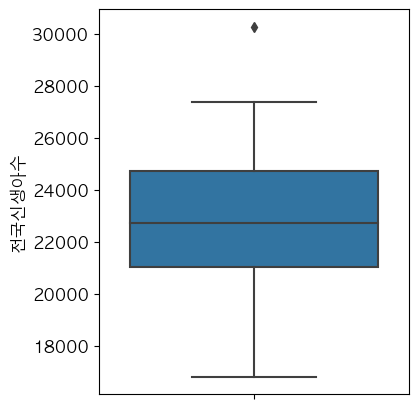

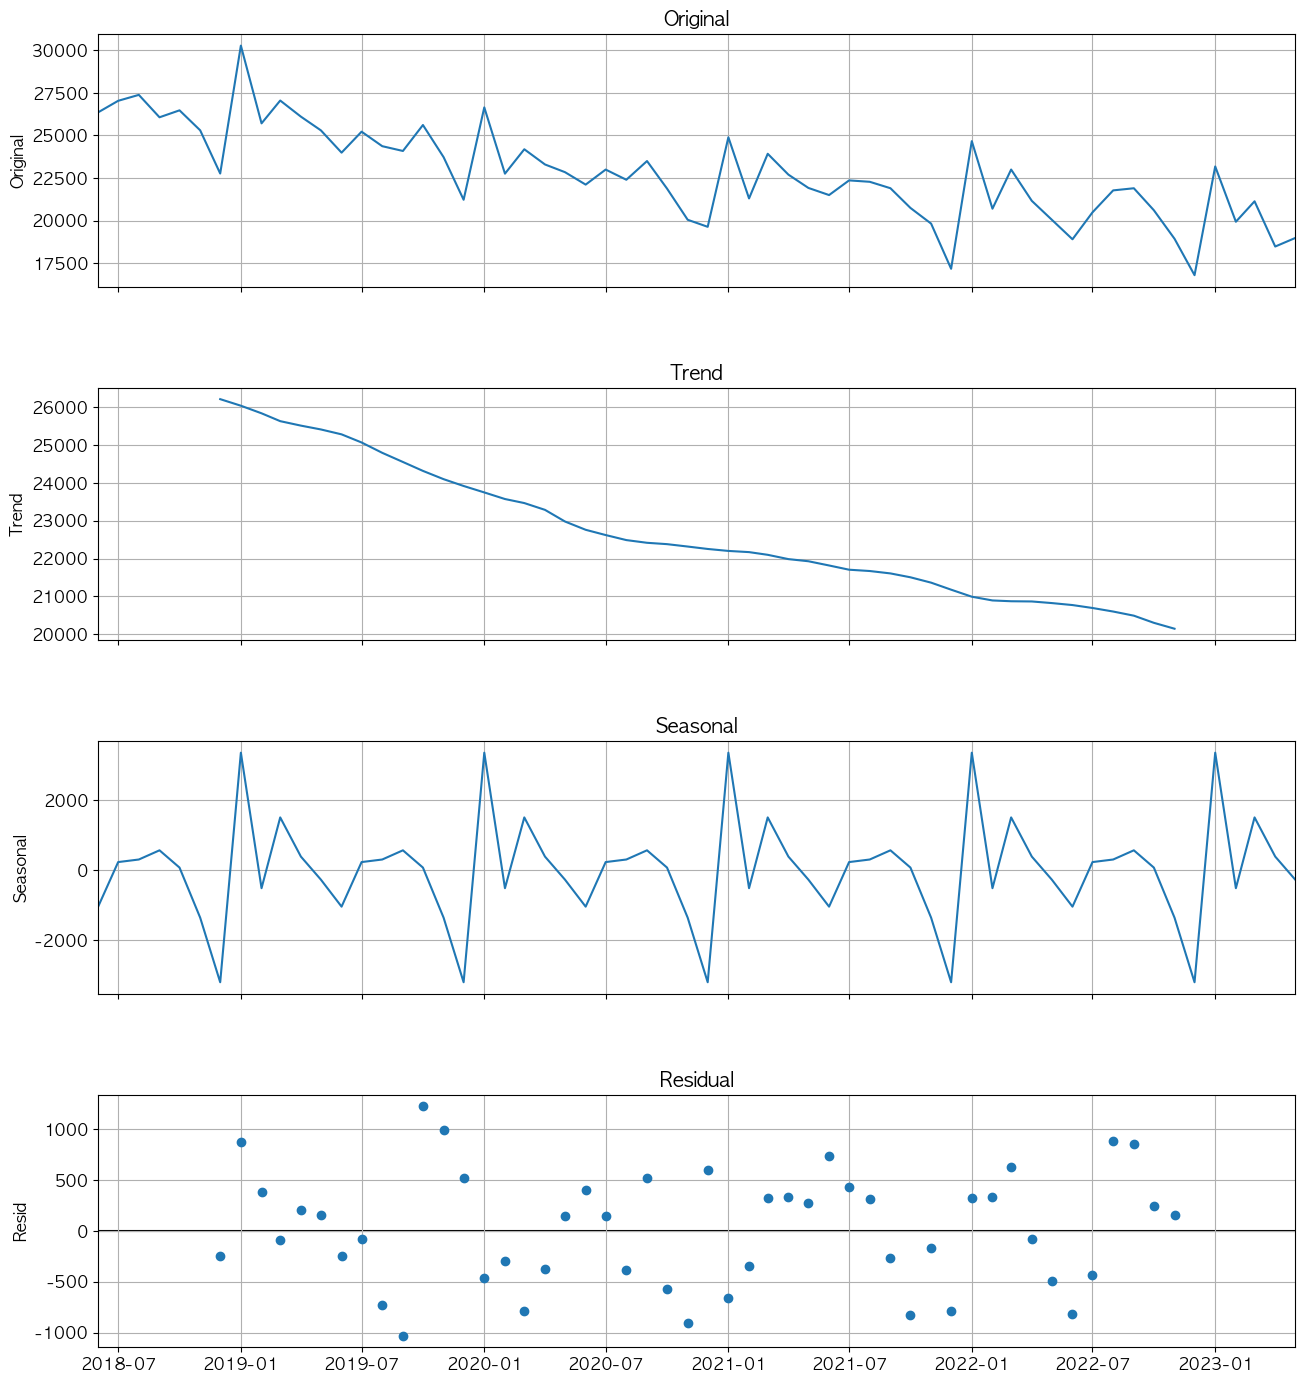

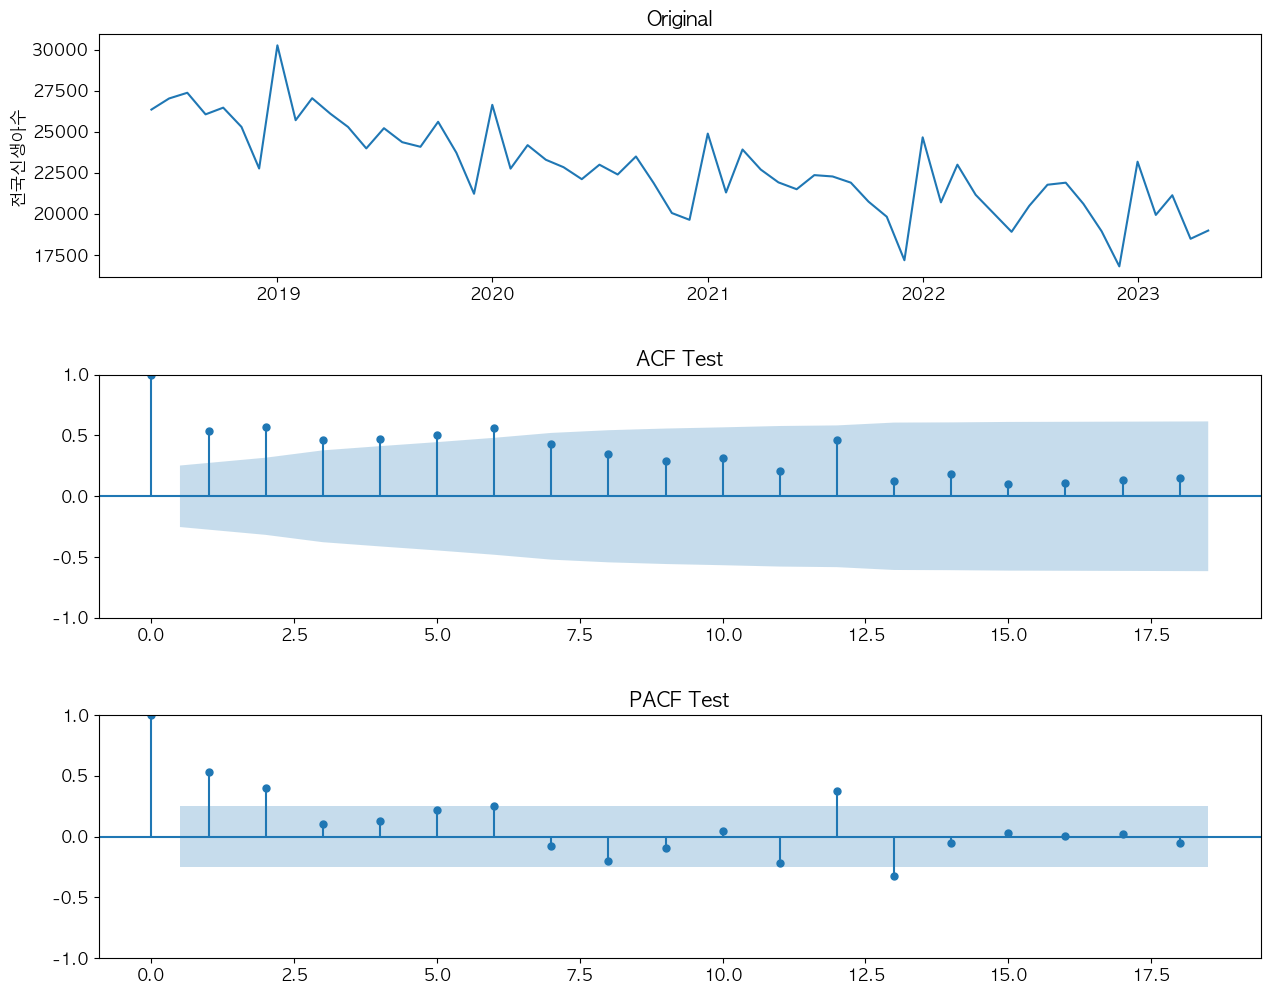

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -3.12888 |
| 유의수준(p-value)                  | 0.0244887 |
| 최적차수(num of lags)              |        11 |
| 관측치 개수(num of observations)   |        48 |
| 기각값(Critical Values) 1%         |  -3.57459 |
| 기각값(Critical Values) 5%         |  -2.92395 |
| 기각값(Critical Values) 10%        |  -2.60004 |
| 데이터 정상성 여부(0=Flase,1=True) |         1 |
+------------------------------------+-----------+


In [79]:
# 데이터 검정
exp_time_data(data = df2, yname = '전국신생아수', sd_model = 'a')


> 극단치 존재: 2019-01, 30271.0
>
> 하락 추세
>
> 계절성을 띔: 1년 (12개월) 주기로 보임
>
> ACF Test 가 더 완만해 보임
> 
> 그래프 진입: p = 1, d(차분 횟수) = 0, q = 0, s = 12


[datazets] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                                    SARIMAX Results                                     
Dep. Variable:                           전국신생아수   No. Observations:                   60
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -510.682
Date:                          Tue, 08 Aug 2023   AIC                           1029.364
Time:                                  16:56:32   BIC                           1037.741
Sample:                              06-01-2018   HQIC                          1032.641
                                   - 05-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.28e+04   4531.049      5.031      0.000    1.39e+04    3.17e+04
ar.L1          0.8133      0.088      9.248      0.

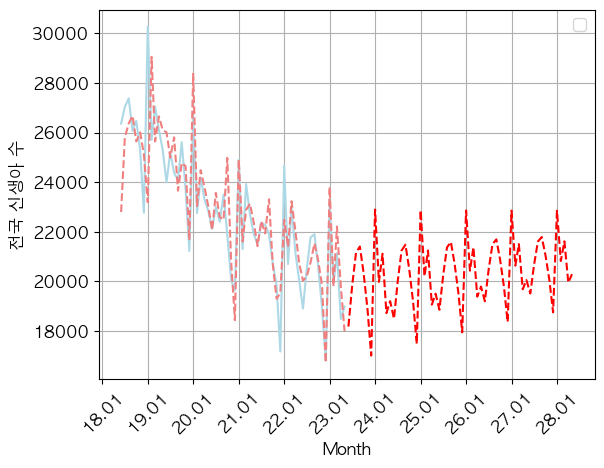

In [86]:
# ARIMA(정석) 분석

# 분석모델 만들기
model = ARIMA(df2['전국신생아수'], order=(1,0,0), seasonal_order=(1,0,0,12))
my_fit = model.fit()
print(my_fit.summary())

# 학습 데이터에 대한 예측치
fv = my_fit.fittedvalues
fv.head()

# 학습 내용 기반 이후 5년 간의 예상치 생성
fc = my_fit.forecast(12*5)
fc.head()

# 시각화

plt.figure()
# 원본
sb.lineplot(x=df2.index, y=df2['전국신생아수'], color='lightblue')
# 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=fv.index, y=fv, linestyle = '--', color='lightcoral')        
# 이후 5년을 예측한 값 
sb.lineplot(x=fc.index, y=fc, linestyle = '--', color = 'red') 

plt. legend()       
plt.xlabel('Month')
plt.ylabel('전국 신생아 수')
plt.xticks(rotation = 45)

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()